# Spooky author classification challenge

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, log_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import keras.backend as K

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_sub = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
print(train.shape)
print(test.shape)

(19579, 3)
(8392, 2)


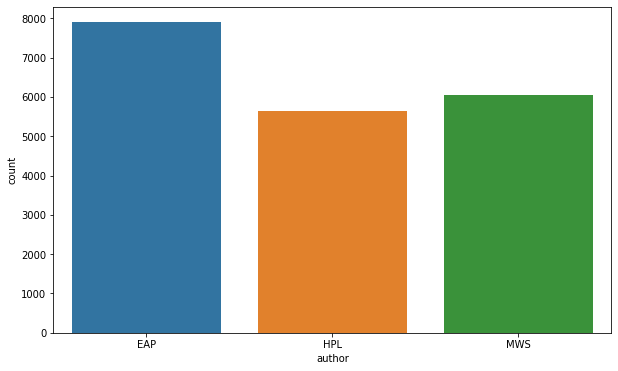

In [5]:
plt.figure(figsize = (10,6))
sns.countplot(train.author);

There's only a slight imbalance in the target class.

- **Map the author name abbreviations to integers.**

In [6]:
train.loc[:, 'author'] = train.author.map({'EAP':0, 'HPL': 1, 'MWS': 2})

### Text preprocessing

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 



def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    words = [w for w in tokenizer.tokenize(text.lower()) if not w in stop_words]  # convert to lowercase and remove stopwords
    words = [w for w in words if len(w)>2] # remove words less than 3 letters long
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w, pos= get_wordnet_pos(w)) for w in words]) ## lemmatization
    return lemmatized_text

In [8]:
# Apply the preprocessing steps to the train text
train.loc[:, 'text'] = train.text.apply(lambda text: preprocess_text(text))
train.text

0        process however afford mean ascertain dimensio...
1                    never occur fumble might mere mistake
2        left hand gold snuff box caper hill cut manner...
3        lovely spring look windsor terrace sixteen fer...
4        find nothing else even gold superintendent aba...
                               ...                        
19574    could fancy look eminent landscape painter bui...
19575                          lid clenched together spasm
19576    mais faut agir say frenchman never faint outright
19577                 item news like strike coolly receive
19578    laid gnarl claw shoulder seem shake altogether...
Name: text, Length: 19579, dtype: object

In [9]:
train.text.apply(lambda snippet: len(snippet)).describe()

count    19579.000000
mean        88.284642
std         65.730563
min          0.000000
25%         46.000000
50%         75.000000
75%        115.000000
max       2848.000000
Name: text, dtype: float64

In [10]:
ind_to_drop = np.where(train.text.apply(lambda s: len(s)==0))[0]
ind_to_drop

array([ 477, 1023, 3601, 3734, 8654])

In [11]:
train = train.drop(ind_to_drop,axis=0)

max length: 4663


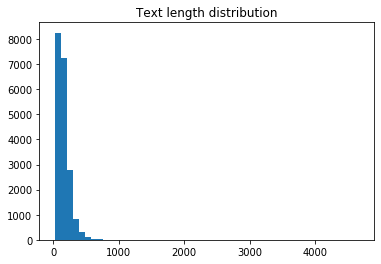

In [130]:
MAX_LENGTH = max(map(len, train.text))
print("max length:", MAX_LENGTH)

plt.title('Text length distribution')
plt.hist(list(map(len, train.text)), bins=50);

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
                                                  shuffle=True, random_state=999, stratify = train.author)

In [15]:
tfidf = TfidfVectorizer(ngram_range = (1,2), strip_accents= 'unicode',
                       max_df= 0.5, min_df = 5, analyzer= 'word', 
                       max_features = 10000, sublinear_tf=True)

count_vec = CountVectorizer(ngram_range = (1,2), strip_accents= 'unicode',
                       max_df= 0.5, min_df = 5, analyzer= 'word', 
                       max_features = 10000)
## Fit on the training set
tfidf.fit(X_train.text)
count_vec.fit(X_train.text)

# Transform both the training set and the test set with the transformer
tfidf_train = tfidf.transform(X_train.text)
tfidf_test = tfidf.transform(X_test.text)

countvec_train = count_vec.transform(X_train.text)
countvec_test = count_vec.transform(X_test.text)

In [16]:
print(tfidf_train.shape)
print(tfidf_test.shape)
print(countvec_train.shape)
print(countvec_test.shape)

(15659, 6905)
(3915, 6905)
(15659, 6905)
(3915, 6905)


In [17]:
def get_top_n_tokens(vectorizer, vectorizer_name, df, top_n = 5):

    feature_names = vectorizer.get_feature_names()
    scores = np.sum(df.A, axis=0,keepdims=False)
    p=[]
    for tag, score in zip(feature_names, scores):
        p.append((tag, score))
    scores_df = pd.DataFrame(p,columns=['token', '%s score'%(vectorizer_name)]).sort_values(by = '%s score'%(vectorizer_name), ascending=False)
    return scores_df.head(top_n)

In [18]:
get_top_n_tokens(tfidf, 'tfidf', tfidf_train, top_n = 5)

,token,tfidf score
4226,one,191.311344
5237,say,180.107934
1241,could,168.762207
6422,upon,164.591504
6811,would,157.148996


In [19]:
get_top_n_tokens(count_vec, 'Count_vec', countvec_train, top_n = 5)

,token,Count_vec score
4226,one,1335
6422,upon,1149
1241,could,1067
5237,say,972
6811,would,961


In [20]:
def grid_search(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None,verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=5, verbose =verbose)
    gs.fit(X, y)
    print ("Best parameter values: {}\n Best mean CV score = {:.4} and std. dev. = {:.4}".format(gs.best_params_ , 
                                                                      gs.best_score_, 
                                                                      gs.cv_results_['std_test_score'][gs.best_index_]))
    best = gs.best_estimator_
    return best

def show_metrics(y_test,y_pred, y_pred_proba):
    print(classification_report(y_test, y_pred ))
    display(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns= ['Predicted EAP', 'Predicted HPL', 'predicted MWS'], 
                         index = ['Actual EAP', 'Actual HPL', 'Actual MWS']))
    print('The multiclass logloss is {}'.format(log_loss(y_test, y_pred_proba)))
    
mlogloss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

#### Naive Bayes

In [21]:
clf_mulNB = MultinomialNB()
parameters = {'alpha': np.arange(0.01, 0.1,0.01)}
mulNB_model = grid_search(clf_mulNB, parameters, tfidf_train, y_train, n_folds=5, score_func= mlogloss)

Best parameter values: {'alpha': 0.04}
 Best mean CV score = -0.4703 and std. dev. = 0.006535


In [22]:
print("------------- Naive Bayes -----------")
show_metrics(y_test, mulNB_model.predict(tfidf_test), mulNB_model.predict_proba(tfidf_test))

------------- Naive Bayes -----------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1580
           1       0.83      0.80      0.82      1127
           2       0.82      0.82      0.82      1208

    accuracy                           0.82      3915
   macro avg       0.82      0.82      0.82      3915
weighted avg       0.82      0.82      0.82      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1318,118,144
Actual HPL,155,903,69
Actual MWS,153,65,990


The multiclass logloss is 0.47171543459944715


In [23]:
clf_mulNBcount = MultinomialNB()
parameters = {'alpha': np.arange(1, 10,1)}
mulNB_model_count = grid_search(clf_mulNBcount, parameters, countvec_train, y_train, n_folds = 5, score_func= mlogloss)

print("------------- Naive Bayes with Count vectorizer -----------")
show_metrics(y_test, mulNB_model_count.predict(countvec_test), mulNB_model_count.predict_proba(countvec_test))

Best parameter values: {'alpha': 3}
 Best mean CV score = -0.4897 and std. dev. = 0.01628
------------- Naive Bayes with Count vectorizer -----------
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1580
           1       0.81      0.80      0.80      1127
           2       0.80      0.82      0.81      1208

    accuracy                           0.81      3915
   macro avg       0.81      0.81      0.81      3915
weighted avg       0.81      0.81      0.81      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1271,134,175
Actual HPL,156,896,75
Actual MWS,130,83,995


The multiclass logloss is 0.49246883757328414


In [24]:
cv_scores = cross_val_score(mulNB_model_count,countvec_train,y_train, cv = 5, scoring = mlogloss)
print("Mean CV score: {} and std. dev.: {}".format(np.mean(cv_scores), np.std(cv_scores)))

Mean CV score: -0.4896681602003466 and std. dev.: 0.01627615402618388


#### Logistic regression

In [25]:
clf_logreg = LogisticRegression(solver='sag',random_state=23, class_weight= 'balanced')
parameters = {'C': np.arange(1,11,1), 'penalty': ['l1', 'l2']}
logreg_model = grid_search(clf_logreg, parameters, tfidf_train, y_train, n_folds=5, score_func=mlogloss)

Best parameter values: {'C': 5, 'penalty': 'l2'}
 Best mean CV score = -0.5014 and std. dev. = 0.008957


In [26]:
print("------------- Logistic regression -----------")
show_metrics(y_test, logreg_model.predict(tfidf_test), logreg_model.predict_proba(tfidf_test))

------------- Logistic regression -----------
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1580
           1       0.78      0.81      0.80      1127
           2       0.81      0.80      0.80      1208

    accuracy                           0.80      3915
   macro avg       0.80      0.80      0.80      3915
weighted avg       0.80      0.80      0.80      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1261,170,149
Actual HPL,144,912,71
Actual MWS,164,83,961


The multiclass logloss is 0.485967595573491


#### XGBoost

In [27]:
xgb_model = XGBClassifier(max_depth= 3, n_estimators=500, n_jobs=-1,learning_rate=0.15, reg_lambda=1,
                          colsample_bytree = 0.5, random_state=22, subsample = 1.)
xgb_model.fit(tfidf_train, y_train, eval_metric =  ['mlogloss'], eval_set = [(tfidf_train,y_train), (tfidf_test, y_test)],
             early_stopping_rounds = 50)

[0]	validation_0-mlogloss:1.08808	validation_1-mlogloss:1.08778
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.07847	validation_1-mlogloss:1.07836
[2]	validation_0-mlogloss:1.06907	validation_1-mlogloss:1.06886
[3]	validation_0-mlogloss:1.05905	validation_1-mlogloss:1.05952
[4]	validation_0-mlogloss:1.05038	validation_1-mlogloss:1.05056
[5]	validation_0-mlogloss:1.04393	validation_1-mlogloss:1.04384
[6]	validation_0-mlogloss:1.03708	validation_1-mlogloss:1.03685
[7]	validation_0-mlogloss:1.03077	validation_1-mlogloss:1.0306
[8]	validation_0-mlogloss:1.02474	validation_1-mlogloss:1.025
[9]	validation_0-mlogloss:1.01998	validation_1-mlogloss:1.02089
[10]	validation_0-mlogloss:1.0149	validation_1-mlogloss:1.01603
[11]	validation_0-mlogloss:1.01057	validation_1-mlogloss:1.01183
[12]	validation_0-mlogloss:1.00591	validation_1-mlogloss:1.00801
[1

[121]	validation_0-mlogloss:0.808955	validation_1-mlogloss:0.843721
[122]	validation_0-mlogloss:0.807959	validation_1-mlogloss:0.842842
[123]	validation_0-mlogloss:0.806934	validation_1-mlogloss:0.841988
[124]	validation_0-mlogloss:0.805923	validation_1-mlogloss:0.841139
[125]	validation_0-mlogloss:0.804926	validation_1-mlogloss:0.840306
[126]	validation_0-mlogloss:0.80395	validation_1-mlogloss:0.839609
[127]	validation_0-mlogloss:0.802985	validation_1-mlogloss:0.83883
[128]	validation_0-mlogloss:0.802006	validation_1-mlogloss:0.838102
[129]	validation_0-mlogloss:0.80104	validation_1-mlogloss:0.837355
[130]	validation_0-mlogloss:0.799952	validation_1-mlogloss:0.83654
[131]	validation_0-mlogloss:0.799043	validation_1-mlogloss:0.835852
[132]	validation_0-mlogloss:0.798121	validation_1-mlogloss:0.834942
[133]	validation_0-mlogloss:0.797162	validation_1-mlogloss:0.834428
[134]	validation_0-mlogloss:0.796103	validation_1-mlogloss:0.834
[135]	validation_0-mlogloss:0.795153	validation_1-mlogl

[243]	validation_0-mlogloss:0.713357	validation_1-mlogloss:0.775497
[244]	validation_0-mlogloss:0.71275	validation_1-mlogloss:0.775201
[245]	validation_0-mlogloss:0.712143	validation_1-mlogloss:0.774689
[246]	validation_0-mlogloss:0.711581	validation_1-mlogloss:0.774323
[247]	validation_0-mlogloss:0.710961	validation_1-mlogloss:0.773822
[248]	validation_0-mlogloss:0.710383	validation_1-mlogloss:0.77328
[249]	validation_0-mlogloss:0.709725	validation_1-mlogloss:0.772921
[250]	validation_0-mlogloss:0.709138	validation_1-mlogloss:0.772515
[251]	validation_0-mlogloss:0.708558	validation_1-mlogloss:0.771952
[252]	validation_0-mlogloss:0.707945	validation_1-mlogloss:0.771674
[253]	validation_0-mlogloss:0.707379	validation_1-mlogloss:0.771058
[254]	validation_0-mlogloss:0.706801	validation_1-mlogloss:0.770811
[255]	validation_0-mlogloss:0.706222	validation_1-mlogloss:0.770398
[256]	validation_0-mlogloss:0.705653	validation_1-mlogloss:0.770145
[257]	validation_0-mlogloss:0.705055	validation_1-

[364]	validation_0-mlogloss:0.650545	validation_1-mlogloss:0.734098
[365]	validation_0-mlogloss:0.65003	validation_1-mlogloss:0.733766
[366]	validation_0-mlogloss:0.649609	validation_1-mlogloss:0.733451
[367]	validation_0-mlogloss:0.649133	validation_1-mlogloss:0.733301
[368]	validation_0-mlogloss:0.648713	validation_1-mlogloss:0.733013
[369]	validation_0-mlogloss:0.648295	validation_1-mlogloss:0.732787
[370]	validation_0-mlogloss:0.647838	validation_1-mlogloss:0.732549
[371]	validation_0-mlogloss:0.647407	validation_1-mlogloss:0.732248
[372]	validation_0-mlogloss:0.646933	validation_1-mlogloss:0.731946
[373]	validation_0-mlogloss:0.646447	validation_1-mlogloss:0.731695
[374]	validation_0-mlogloss:0.645969	validation_1-mlogloss:0.731373
[375]	validation_0-mlogloss:0.645564	validation_1-mlogloss:0.731153
[376]	validation_0-mlogloss:0.645105	validation_1-mlogloss:0.730856
[377]	validation_0-mlogloss:0.64468	validation_1-mlogloss:0.730512
[378]	validation_0-mlogloss:0.644251	validation_1-

[485]	validation_0-mlogloss:0.602597	validation_1-mlogloss:0.704946
[486]	validation_0-mlogloss:0.602266	validation_1-mlogloss:0.704727
[487]	validation_0-mlogloss:0.601941	validation_1-mlogloss:0.704418
[488]	validation_0-mlogloss:0.60158	validation_1-mlogloss:0.704263
[489]	validation_0-mlogloss:0.601243	validation_1-mlogloss:0.704014
[490]	validation_0-mlogloss:0.600874	validation_1-mlogloss:0.703747
[491]	validation_0-mlogloss:0.600509	validation_1-mlogloss:0.70345
[492]	validation_0-mlogloss:0.600187	validation_1-mlogloss:0.703244
[493]	validation_0-mlogloss:0.599832	validation_1-mlogloss:0.70312
[494]	validation_0-mlogloss:0.599504	validation_1-mlogloss:0.702896
[495]	validation_0-mlogloss:0.599086	validation_1-mlogloss:0.702576
[496]	validation_0-mlogloss:0.598765	validation_1-mlogloss:0.702309
[497]	validation_0-mlogloss:0.598424	validation_1-mlogloss:0.701984
[498]	validation_0-mlogloss:0.59807	validation_1-mlogloss:0.701739
[499]	validation_0-mlogloss:0.597722	validation_1-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [28]:
print("------------- XGBoost -----------")
show_metrics(y_test, xgb_model.predict(tfidf_test), xgb_model.predict_proba(tfidf_test))

------------- XGBoost -----------
              precision    recall  f1-score   support

           0       0.65      0.89      0.75      1580
           1       0.79      0.62      0.70      1127
           2       0.82      0.58      0.68      1208

    accuracy                           0.72      3915
   macro avg       0.75      0.70      0.71      3915
weighted avg       0.74      0.72      0.71      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1402,96,82
Actual HPL,347,703,77
Actual MWS,410,92,706


The multiclass logloss is 0.7014815384936448


In [ ]:
cv_scores_xgb = cross_val_score(xgb_model,tfidf_train,y_train, cv = 5, scoring = mlogloss)

In [ ]:
print("Mean CV score: {} and std. dev.: {}".format(np.mean(cv_scores_xgb), np.std(cv_scores_xgb)))

## Word vectors (GloVe)

In [40]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words, words_to_index, index_to_words, word_to_vec_map



emb_dim = 100 # Get the 100-dim Glove vectors
words, words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('../input/glove_6B/glove.6B.{}d.txt'.format(emb_dim))

In [41]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (glove_vec_size,)
    """
    
    words = word_tokenize(sentence.lower())
    words = [w for w in words if w.isalpha()]
    # Initialize the average word vector
    avg = np.zeros(shape = (emb_dim,))
    
    # Average the word vectors.
    total = np.zeros(shape = (emb_dim,))
    for w in words:
        if w not in word_to_vec_map.keys():
            continue
        total += word_to_vec_map[w]
    if len(words) >0:
        avg = total/len(words)
#    tot_norm = total/np.sqrt(np.sum((total)**2))
    return avg

In [42]:
train = pd.read_csv('../input/train.csv')
train.loc[:, 'author'] = train.author.map({'EAP':0, 'HPL': 1, 'MWS': 2})
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
                                                  shuffle=True, random_state=9999, stratify = train.author)

In [43]:
X_train_glove = [sentence_to_avg(x, word_to_vec_map) for x in X_train.text]
X_test_glove =  [sentence_to_avg(x, word_to_vec_map) for x in X_test.text]

X_train_glove = np.stack(X_train_glove,axis=0)
X_test_glove = np.stack(X_test_glove,axis=0)

In [45]:
sc = StandardScaler()
X_train_glove_sc = sc.fit_transform(X_train_glove)
X_test_glove_sc = sc.transform(X_test_glove)

In [52]:
clf_logreg_glove = LogisticRegression(solver='sag',random_state=23, class_weight= 'balanced')
parameters = {'C': [0.001,0.005,0.01,0.05,0.1]}
logreg_glove_model = grid_search(clf_logreg_glove, parameters, X_train_glove_sc, y_train, n_folds=5, score_func=mlogloss)


print('Train logloss: ',log_loss(y_train,logreg_glove_model.predict_proba(X_train_glove_sc)))
print('Test logloss: ',log_loss(y_test,logreg_glove_model.predict_proba(X_test_glove_sc)))

Best parameter values: {'C': 0.01}
 Best mean CV score = -0.8242 and std. dev. = 0.01149
Train logloss:  0.808987578717734
Test logloss:  0.8134586541872701


In [58]:
xgb_model = XGBClassifier(max_depth= 3, n_estimators=300, n_jobs=-1,learning_rate=0.1, reg_lambda=1.5,
                          colsample_bytree = 0.5, random_state=22, subsample = 0.8)
xgb_model.fit(X_train_glove_sc, y_train, eval_metric =  ['mlogloss'], eval_set = [(X_train_glove_sc,y_train), (X_test_glove_sc, y_test)],
             early_stopping_rounds = 30)


[0]	validation_0-mlogloss:1.08396	validation_1-mlogloss:1.08543
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.06977	validation_1-mlogloss:1.07194
[2]	validation_0-mlogloss:1.05815	validation_1-mlogloss:1.06123
[3]	validation_0-mlogloss:1.0459	validation_1-mlogloss:1.04977
[4]	validation_0-mlogloss:1.03496	validation_1-mlogloss:1.04019
[5]	validation_0-mlogloss:1.02554	validation_1-mlogloss:1.03148
[6]	validation_0-mlogloss:1.01568	validation_1-mlogloss:1.02267
[7]	validation_0-mlogloss:1.00613	validation_1-mlogloss:1.01434
[8]	validation_0-mlogloss:0.99915	validation_1-mlogloss:1.00816
[9]	validation_0-mlogloss:0.991048	validation_1-mlogloss:1.00057
[10]	validation_0-mlogloss:0.983936	validation_1-mlogloss:0.994245
[11]	validation_0-mlogloss:0.976674	validation_1-mlogloss:0.987518
[12]	validation_0-mlogloss:0.970081	validation_1-mlogloss:0

[121]	validation_0-mlogloss:0.743226	validation_1-mlogloss:0.817162
[122]	validation_0-mlogloss:0.742224	validation_1-mlogloss:0.816701
[123]	validation_0-mlogloss:0.741274	validation_1-mlogloss:0.81639
[124]	validation_0-mlogloss:0.74037	validation_1-mlogloss:0.815924
[125]	validation_0-mlogloss:0.739374	validation_1-mlogloss:0.815508
[126]	validation_0-mlogloss:0.73835	validation_1-mlogloss:0.815176
[127]	validation_0-mlogloss:0.737407	validation_1-mlogloss:0.81466
[128]	validation_0-mlogloss:0.736445	validation_1-mlogloss:0.814262
[129]	validation_0-mlogloss:0.73556	validation_1-mlogloss:0.813953
[130]	validation_0-mlogloss:0.73458	validation_1-mlogloss:0.813513
[131]	validation_0-mlogloss:0.733677	validation_1-mlogloss:0.813033
[132]	validation_0-mlogloss:0.732821	validation_1-mlogloss:0.812886
[133]	validation_0-mlogloss:0.732061	validation_1-mlogloss:0.812552
[134]	validation_0-mlogloss:0.731155	validation_1-mlogloss:0.812271
[135]	validation_0-mlogloss:0.730257	validation_1-mlog

[242]	validation_0-mlogloss:0.655673	validation_1-mlogloss:0.784285
[243]	validation_0-mlogloss:0.655106	validation_1-mlogloss:0.784153
[244]	validation_0-mlogloss:0.654584	validation_1-mlogloss:0.7839
[245]	validation_0-mlogloss:0.654028	validation_1-mlogloss:0.783838
[246]	validation_0-mlogloss:0.653441	validation_1-mlogloss:0.783566
[247]	validation_0-mlogloss:0.652822	validation_1-mlogloss:0.783382
[248]	validation_0-mlogloss:0.652195	validation_1-mlogloss:0.783199
[249]	validation_0-mlogloss:0.651648	validation_1-mlogloss:0.783011
[250]	validation_0-mlogloss:0.651028	validation_1-mlogloss:0.782854
[251]	validation_0-mlogloss:0.65044	validation_1-mlogloss:0.782611
[252]	validation_0-mlogloss:0.649831	validation_1-mlogloss:0.782355
[253]	validation_0-mlogloss:0.649312	validation_1-mlogloss:0.782212
[254]	validation_0-mlogloss:0.64876	validation_1-mlogloss:0.782105
[255]	validation_0-mlogloss:0.648249	validation_1-mlogloss:0.781922
[256]	validation_0-mlogloss:0.647641	validation_1-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=22,
              reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [59]:
show_metrics(y_test, xgb_model.predict(X_test_glove_sc), xgb_model.predict_proba(X_test_glove_sc))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68      1580
           1       0.66      0.61      0.63      1127
           2       0.66      0.66      0.66      1209

    accuracy                           0.66      3916
   macro avg       0.66      0.66      0.66      3916
weighted avg       0.66      0.66      0.66      3916



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1114,208,258
Actual HPL,293,685,149
Actual MWS,273,142,794


The multiclass logloss is 0.7757807170308221


### LSTM sequence model

In [102]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def tokenize(text_corpus):
    '''
    Tokenize the corpus and return the tokenizer object
    '''
    tokenizer = Tokenizer(filters='', lower=True)
    tokenizer.fit_on_texts(text_corpus)
    return tokenizer

def text_to_seq(tokenizer, text_corpus, max_len):
    '''
    Return the word indices array to be used as input for Keras Embedding layer
    Arguments:
    max_len -- Maximum sequence length to be used for padding
    '''
    tensor = tokenizer.texts_to_sequences(text_corpus)
    tensor = pad_sequences(tensor,maxlen=max_len, padding='post')
    return tensor

def create_embedding_matrix(word_to_vec_map, word_index, emb_dim):
    vocab_len = len(word_index) + 1
    embedding_matrix = np.zeros(shape = (vocab_len, emb_dim))
    for word, idx in word_index.items():
        emb_vector = word_to_vec_map.get(word)
        if emb_vector is not None:
            embedding_matrix[idx,:] = emb_vector
    return embedding_matrix

def create_model(word_to_vec_map, word_index, emb_dim, max_len):
    '''
    Returns a Keras model two LSTM layers followed by a dense layer with softmax activation.
    
    Arguments:
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary
    emb_dim -- dimenesion of the word embedding

    Returns:
    model -- a model instance in Keras
    '''
    vocab_len = len(word_index) + 1
    embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
    embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)                             
    model = Sequential()
    model.add(embedding_layer)
#    model.add(LSTM(128, return_sequences = True))
#    model.add(Dropout(rate = 0.2))
    model.add(LSTM(256, return_sequences = False))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dense(units = 3))
    model.add(Activation('softmax'))
    return model

In [132]:
emb_dim = 100
max_len = 200

tokenizer = tokenize(train.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_emb = text_to_seq(tokenizer, text_corpus = X_train.text, max_len = max_len)
X_test_emb = text_to_seq(tokenizer, text_corpus =  X_test.text, max_len = max_len)

print('{} training examples exceeded max_len\n'.format(np.sum(X_train_emb[:, max_len-1]!=0)))

Y_train_oh = convert_to_one_hot(y_train.values, C = 3)
Y_test_oh = convert_to_one_hot(y_test.values, C = 3)

K.clear_session()
model = create_model(word_to_vec_map, word_index, emb_dim, max_len)
model.summary()

Found 44895 unique tokens.
3 training examples exceeded max_len

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          4489600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 4,921,731
Trainable params: 432,131
Non-t

In [133]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [134]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train_emb, Y_train_oh, batch_size=512, epochs=2, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/2
15663/15663 [==============================] - 332s 21ms/step - loss: 1.0891 - val_loss: 1.0889
Epoch 2/2
15663/15663 [==============================] - 334s 21ms/step - loss: 1.2033 - val_loss: 1.0879


In [112]:
loss = model.evaluate(X_test_emb, Y_test_oh)
print("Logloss on test set: ", loss)

3916/3916 [==============================] - 41s 10ms/step
Logloss on test set:  1.0879048559590185


In [113]:
pred = model.predict(X_test_emb)

In [125]:
# This code allows you to see the mislabelled examples
for i in range(len(X_test_emb)):
    num = np.argmax(pred[i])
    if(num != y_test.values[i]):
        print('Expected author: {} prediction: {} '.format (y_test.values[i], num))

Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected autho

Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 1 prediction: 0 
Expected author: 2 prediction: 0 
Expected author: 2 prediction: 0 
Expected autho

In [ ]:
'''
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)
'''